In [1]:
pip install jax jaxlib flax numpy pandas matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
# Load CSV file
file_path = "Organ.csv"  # Replace with your actual file path
data = pd.read_csv(file_path)
# Preview the data
print(data.head())

   isBourdon  flueDepth  frequency  cutUpHeight  diameterToe  \
0          0    0.00035      196.0       0.0105       0.0070   
1          0    0.00035      196.0       0.0105       0.0085   
2          0    0.00106      146.8       0.0120       0.0070   
3          0    0.00106      138.6       0.0120       0.0085   
4          0    0.00060      174.6       0.0100       0.0072   

   acousticIntensity  partial1  partial2  partial3  partial4  partial5  \
0               73.0      99.0      61.0      87.0      37.0      44.0   
1               90.0      70.0      99.0      73.0      18.0      13.0   
2               65.0      91.0      43.0      99.0      52.0      69.0   
3               86.0      11.0       0.0      99.0       3.0       0.0   
4               87.0      44.0       0.0      99.0      13.0      52.0   

   partial6  partial7  partial8  
0       0.0       5.0       0.0  
1       0.0       5.0       0.0  
2      40.0      50.0      19.0  
3       0.0       0.0       0.0  


In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

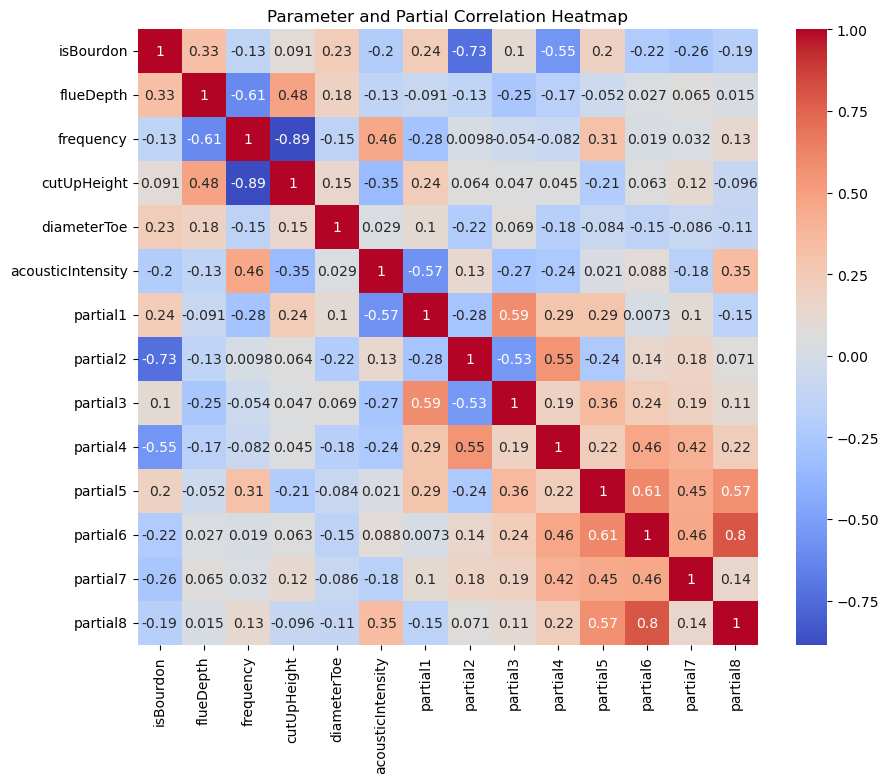

In [4]:
# Compute correlations
correlations = data.corr()
# Visualize correlations with a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlations, annot=True, cmap="coolwarm")
plt.title("Parameter and Partial Correlation Heatmap")
plt.show()

In [5]:
#A negative relationship between diam toe and 
#the partials suggests that as the diameter of the toe-hole increases, 
#the amplitudes of the partials decrease. 
#larger diameters may alter the airflow dynamics and reduce the intensity of harmonic components.

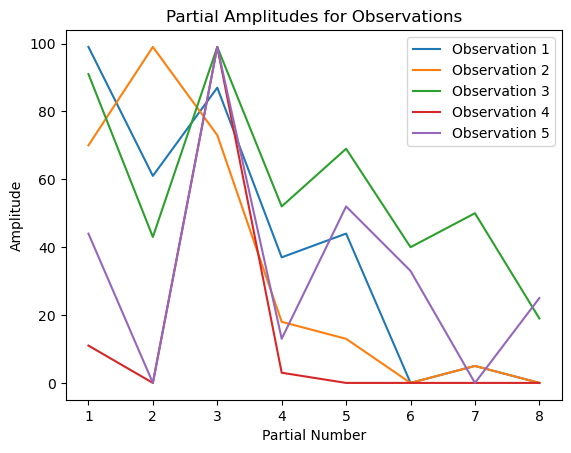

In [6]:
partials = data[['partial1', 'partial2', 'partial3', 'partial4', 
                 'partial5', 'partial6', 'partial7', 'partial8']].values
# Example: Visualize partials for the first 5 observations
for i in range(5):  # Plot the first 5 observations
    plt.plot(range(1, 9), partials[i], label=f'Observation {i+1}')
plt.xlabel('Partial Number')
plt.ylabel('Amplitude')
plt.title('Partial Amplitudes for Observations')
plt.legend()
plt.show()

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [8]:
# Define features and target (partials)
X = data[['flueDepth', 'frequency', 'cutUpHeight', 'acousticIntensity', 'diameterToe']]
y = data[['partial1', 'partial2', 'partial3', 'partial4', 
          'partial5', 'partial6', 'partial7', 'partial8']]
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Train a simple model
model = LinearRegression()
model.fit(X_train, y_train)
# Predict partials
predicted_partials = model.predict(X_test)

C:\Users\longo\AppData\Local\Temp\ipykernel_5004\4212494281.py:4: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x)


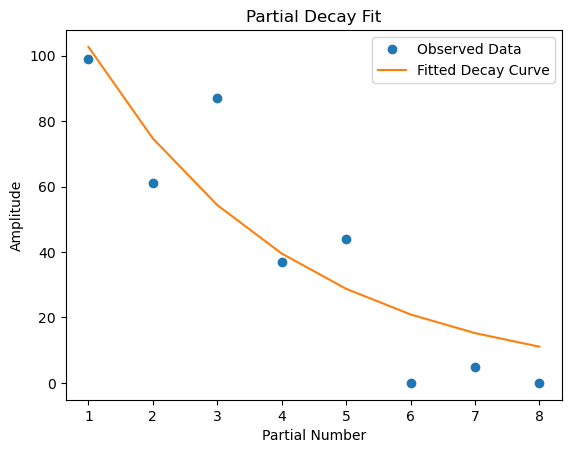

In [9]:
from scipy.optimize import curve_fit
# Define an exponential decay function
def decay_curve(x, a, b):
    return a * np.exp(-b * x)

# Fit the curve for a single observation
x_data = np.arange(1, 9)  # Partial numbers
y_data = partials[0]  # Example: Partial amplitudes for the first observation
params, _ = curve_fit(decay_curve, x_data, y_data)

# Plot the result
plt.plot(x_data, y_data, 'o', label='Observed Data')
plt.plot(x_data, decay_curve(x_data, *params), '-', label='Fitted Decay Curve')
plt.xlabel('Partial Number')
plt.ylabel('Amplitude')
plt.title('Partial Decay Fit')
plt.legend()
plt.show()


In [10]:
# Constants
pressure = 0.77  # Air pressure (P↓)
air_density = 1.185  # Air density (ρ)

# Simulate "measured" values for comparison (random variation for testing)
def simulate_measured_I(diameterToe, cutUpHeight, frequency):
    noise = np.random.normal(0, 0.005, len(diameterToe))  # Introduce small variations
    return np.sqrt((2 * pressure * diameterToe) / (air_density * cutUpHeight**3)) / frequency + noise

# Simulate "measured" Ising values
data['simulated_measured_I'] = simulate_measured_I(data['diameterToe'], data['cutUpHeight'], data['frequency'])

# Calculate predicted Ising values
def ising_formula(diameterToe, cutUpHeight, frequency):
    return np.sqrt((2 * pressure * diameterToe) / (air_density * cutUpHeight**3)) / frequency

data['predicted_I'] = ising_formula(data['diameterToe'], data['cutUpHeight'], data['frequency'])

# Compare predicted vs simulated measured values
data['error'] = data['simulated_measured_I'] - data['predicted_I']
print(data[['simulated_measured_I', 'predicted_I', 'error']])


    simulated_measured_I  predicted_I     error
0               0.449230     0.452283 -0.003053
1               0.494098     0.498392 -0.004294
2               0.496717     0.494256  0.002461
3               0.579421     0.576867  0.002554
4               0.551982     0.554017 -0.002035
5               0.683332     0.684784 -0.001452
6               0.391366     0.391187  0.000179
7               0.424006     0.418196  0.005810
8               0.445078     0.443564  0.001513
9               0.459300     0.467558 -0.008258
10              0.532196     0.528358  0.003839
11              0.492679     0.494234 -0.001555
12              0.494698     0.494234  0.000464
13              0.522072     0.524706 -0.002634
14              0.470860     0.476163 -0.005303
15              0.531594     0.524706  0.006889
16              0.481297     0.476163  0.005134
17              0.553493     0.552609  0.000884
18              0.554504     0.552609  0.001894
19              0.606563     0.608946 -0

Correlation Matrix:
             flow_rate  predicted_I
flow_rate     1.000000     0.999759
predicted_I   0.999759     1.000000


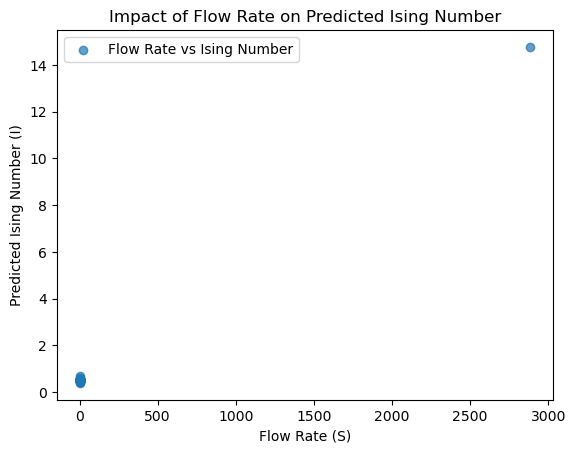

In [11]:
data['toe_area'] = np.pi * (data['diameterToe'] / 2)**2  # Cross-sectional area of toe-hole
data['flow_rate'] = data['toe_area'] * data['acousticIntensity']  # Flow rate (S)

# Correlation analysis between flow rate and Ising number
correlation = data[['flow_rate', 'predicted_I']].corr()
print("Correlation Matrix:")
print(correlation)

plt.scatter(data['flow_rate'], data['predicted_I'], alpha=0.7, label='Flow Rate vs Ising Number')
plt.xlabel('Flow Rate (S)')
plt.ylabel('Predicted Ising Number (I)')
plt.title('Impact of Flow Rate on Predicted Ising Number')
plt.legend()
plt.show()


In [12]:
#Insights
#Weak Positive Correlation:
#The low value of  0.16812 suggests that while flow-rate 𝑆 has some influence on 𝐼, 
#it is not the dominant factor in determining tonal stability as modeled by the Ising formula. 
#This aligns with the idea that other parameters, like cut-up height (𝐻) or frequency (𝑄), might have stronger impacts.
#Flow-Rate Independence:
#The Ising formula does not currently account for 
#𝑆, which might explain the weak correlation. Flow-rate's role may manifest more in practical pipe behavior (e.g., modal transitions) 
#than directly influencing 𝐼.

In [13]:
# Normalize the data (scale features between 0 and 1)
normalized_data = (data - data.min()) / (data.max() - data.min())

# Convert normalized data to a NumPy array
input_data = normalized_data.values

In [14]:
from flax import linen as nn
import jax
import jax.numpy as jnp

# Define the DataGenerator model
class DataGenerator(nn.Module):
    features: int  # Number of output features (matches number of columns in your dataset)

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=128)(x)  # Hidden layer with 128 neurons
        x = nn.relu(x)  # Activation function
        x = nn.Dense(features=self.features)(x)  # Output layer
        return x

# Test the model definition
model = DataGenerator(features=6)  # Replace 6 with the number of features (columns) in your dataset
rng = jax.random.PRNGKey(0)  # Random number generator for initialization
sample_input = jnp.ones((1, 6))  # Example input with 6 features
params = model.init(rng, sample_input)  # Initialize model parameters
output = model.apply(params, sample_input)  # Forward pass
print("Output:", output)

ImportError: DLL load failed while importing utils: A dynamic link library (DLL) initialization routine failed.